# Goals

* Create a tiledb-soma db for the Tahoe-100 dataset

# Vars

In [1]:
work_dir = '/processed_datasets/scRecount/tahoe'

# Init

In [2]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import scanpy as sc
import numpy as np
import plotnine as pn

In [3]:
pn.theme_set(pn.theme_bw())

In [4]:
db_uri = os.path.join(work_dir, 'tiledb-soma')
#db_uri = os.path.join(work_dir, 'tiledb-soma-mini')
db_uri

'/processed_datasets/scRecount/tahoe/tiledb-soma'

# Create

In [6]:
# list all *.h5ad.gz files in the work directory
files = sorted(glob(os.path.join(work_dir, '*.h5ad.gz')))
files

['/processed_datasets/scRecount/tahoe/plate10_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate11_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate12_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate13_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate14_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate1_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate2_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate4_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate5_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate6_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate7_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate8_filtered.h5ad.gz',
 '/processed_datasets/scRecount/tahoe/plate9_filtered.h5ad.gz']

> Ran via tmux to prevent disconnection

```bash
./scripts/tiledb-loader-tahoe.py \
  --h5ad-ext h5ad.gz \
  --db-uri /processed_datasets/scRecount/tahoe/tiledb-soma \
  /processed_datasets/scRecount/tahoe/ \
  > tiledb-loader-tahoe.log 2>&1 
```

# Summary

In [8]:
# get colnames
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
BARCODE_SUB_LIB_ID: large_string
sample: dictionary<values=string, indices=int32, ordered=0>
species: dictionary<values=string, indices=int32, ordered=0>
gene_count: int64
tscp_count: int64
mread_count: int64
bc1_wind: int64
bc2_wind: int64
bc3_wind: int64
bc1_well: dictionary<values=string, indices=int32, ordered=0>
bc2_well: dictionary<values=string, indices=int32, ordered=0>
bc3_well: dictionary<values=string, indices=int32, ordered=0>
id: dictionary<values=string, indices=int32, ordered=0>
drugname_drugconc: dictionary<values=string, indices=int32, ordered=0>
drug: dictionary<values=string, indices=int32, ordered=0>
INT_ID: double
NUM.SNPS: double
NUM.READS: double
demuxlet_call: dictionary<values=string, indices=int32, ordered=0>
BEST.GUESS: dictionary<values=string, indices=int32, ordered=0>
BEST.LLK: double
NEXT.GUESS: dictionary<values=string, indices=int32, ordered=0>
NEXT.LLK: double
DIFF.LLK.BEST.NEXT: double
BEST.POSTERIOR: double
SNG.POSTERIOR: 

## Counts

In [5]:
# total obs
with tiledbsoma.open(db_uri) as exp:
    print(
        exp.obs.read()
        .concat()
        .group_by([])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )

: 

In [92]:
# obs per sample
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['sample'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.head()

(96, 2)


,sample,count_all
0,smp_2771,108978
1,smp_2757,108393
2,smp_2763,95298
3,smp_2751,93738
4,smp_2803,93013


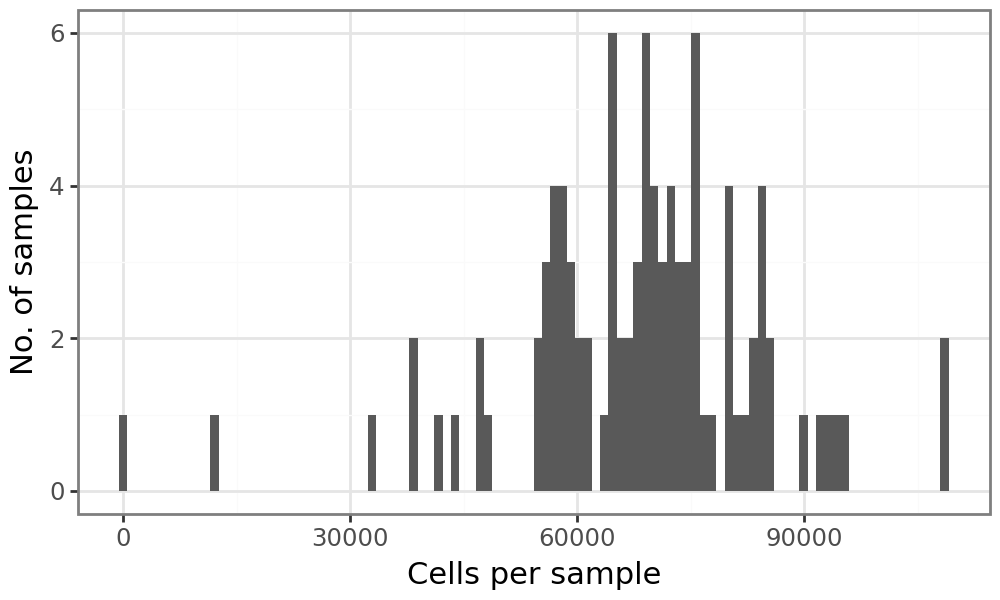

In [93]:
# plot reads per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cells per sample", y="No. of samples") +
    pn.theme(figure_size=(5,3))
    )
p

In [65]:
# reads per cell
with tiledbsoma.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["BARCODE_SUB_LIB_ID", "NUM.READS"])
        .concat()
        .group_by(["BARCODE_SUB_LIB_ID"])
        .aggregate([
            (["NUM.READS"], "sum"),
        ])
        .sort_by([("NUM.READS_sum", "descending")])
        .to_pandas()
    )
df

,BARCODE_SUB_LIB_ID,NUM.READS_sum
0,75_106_106-lib_2527,6570.0
1,82_096_049-lib_2531,5490.0
2,31_171_184-lib_2527,5437.0
3,90_123_042-lib_2529,4833.0
4,34_174_071-lib_2531,4755.0
...,...,...
4705397,89_102_142-lib_1017,10.0
4705398,20_013_189-lib_1009,10.0
4705399,47_105_115-lib_1063,10.0
4705400,24_158_162-lib_1085,10.0


In [66]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["NUM.READS_sum"].describe())

count   4705402
mean        124
std         113
min           7
25%          62
50%          92
75%         147
max        6570
Name: NUM.READS_sum, dtype: float64


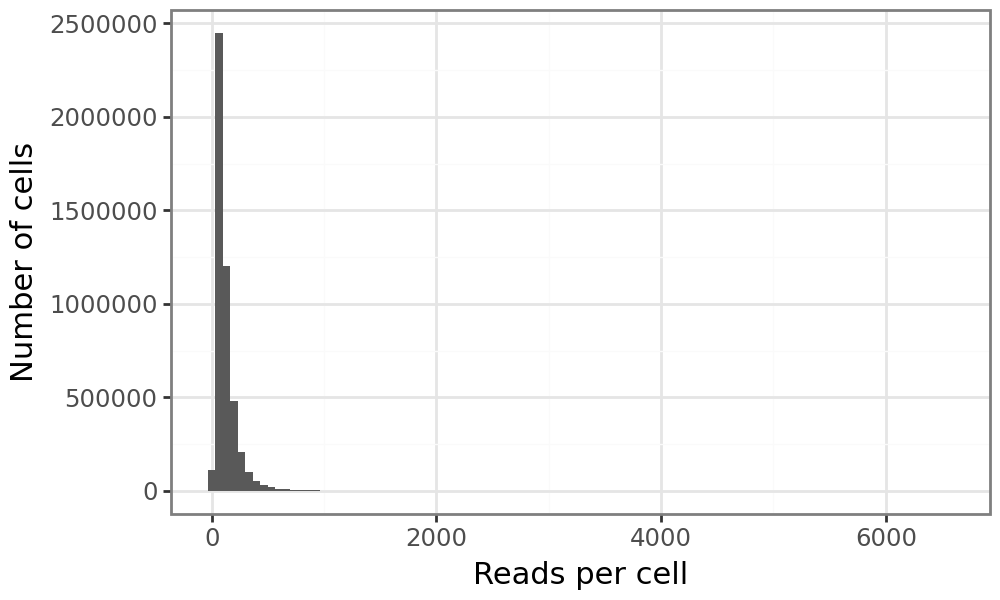

In [67]:
# plot reads per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="NUM.READS_sum")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Reads per cell", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

In [70]:
# gene count per cells
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["BARCODE_SUB_LIB_ID", "gene_count"])
        .concat()
        .to_pandas()
    )
print(df.shape)
df.head()

(4705402, 2)


,BARCODE_SUB_LIB_ID,gene_count
0,01_001_117-lib_1009,1110
1,01_001_122-lib_1009,1011
2,01_001_172-lib_1009,835
3,01_002_058-lib_1009,754
4,01_002_063-lib_1009,1546


In [72]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df["gene_count"].describe())

count   4705402
mean       1208
std         733
min         253
25%         718
50%        1011
75%        1469
max       12600
Name: gene_count, dtype: float64


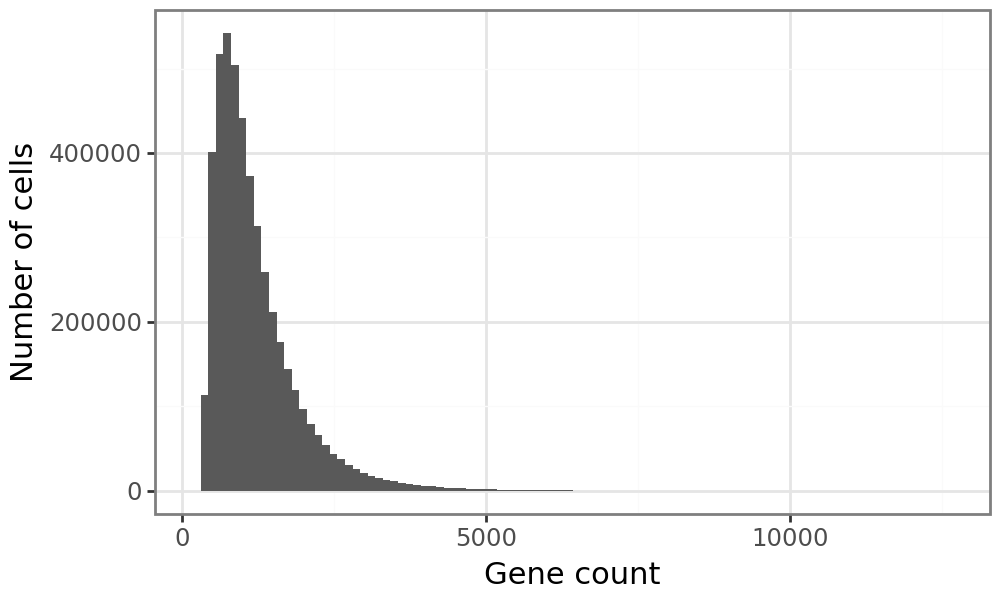

In [71]:
# plot reads per cell (barcode)
p = (
    pn.ggplot(df, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Gene count", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

In [73]:
# cells per drug
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["drug"])
        .concat()
        .group_by(["drug"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(93, 2)


,drug,count_all
0,Infigratinib,51677
1,Erdafitinib,51185
2,Everolimus,117034
3,Pemigatinib,43766
4,Abemaciclib,46168


In [81]:
# cells per cell line/name
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["cell_line", "cell_name"])
        .concat()
        .group_by(["cell_line", "cell_name"])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )
print(df.shape)
df.head()

(50, 3)


,cell_line,cell_name,count_all
0,CVCL_1693,SHP-77,60179
1,CVCL_1495,NCI-H1792,76132
2,CVCL_0399,LoVo,166361
3,CVCL_1056,A498,115706
4,CVCL_0480,PANC-1,158781


In [78]:
# view all metadata
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .slice(0,10) 
        .to_pandas()
    )
pd.set_option('display.max_columns', 100)
print(df.shape)
df.head()

(10, 44)


,soma_joinid,BARCODE_SUB_LIB_ID,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,bc3_well,id,drugname_drugconc,drug,INT_ID,NUM.SNPS,NUM.READS,demuxlet_call,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,cell_line,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL,sublibrary,BARCODE,pcnt_mito,S_score,G2M_score,phase,cell_line_orig,pass_filter,cell_name
0,0,01_001_117-lib_1009,smp_1687,hg38,1110,1404,1655,1,1,117,A1,A1,p2.B9,recM6I4nOji6HKNaj,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,1.0,83.0,83.0,singlet,"CVCL_1693,CVCL_1693,0.00",-26.84,"CVCL_1381,CVCL_1693,0.50",-25.14,-1.70,-31.0,1.0,CVCL_1693,-26.84,CVCL_0028,-33.18,0.0,"CVCL_1381,CVCL_1693,0.50",-25.14,-1.70,lib_1009,01_001_117,0.021368,0.011573,0.188462,G2M,CVCL_1693,full,SHP-77
1,1,01_001_122-lib_1009,smp_1687,hg38,1011,1324,1577,1,1,122,A1,A1,p2.C2,recM6I4nOji6HKNaj,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,2.0,79.0,80.0,singlet,"CVCL_1495,CVCL_1495,0.00",-16.49,"CVCL_1666,CVCL_1495,0.50",-19.04,2.55,-21.0,1.0,CVCL_1495,-16.49,CVCL_0320,-29.51,0.0,"CVCL_1666,CVCL_1495,0.50",-19.04,2.55,lib_1009,01_001_122,0.026435,-0.095618,-0.104762,G1,CVCL_1495,full,NCI-H1792
2,2,01_001_172-lib_1009,smp_1687,hg38,835,1042,1240,1,1,172,A1,A1,p2.G4,recM6I4nOji6HKNaj,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,5.0,75.0,76.0,singlet,"CVCL_0399,CVCL_0399,0.00",-24.71,"CVCL_0399,CVCL_C466,0.50",-25.73,1.02,-29.0,1.0,CVCL_0399,-24.71,CVCL_1495,-37.86,0.0,"CVCL_0399,CVCL_C466,0.50",-25.73,1.02,lib_1009,01_001_172,0.016315,-0.012047,0.015018,G2M,CVCL_0399,full,LoVo
3,3,01_002_058-lib_1009,smp_1687,hg38,754,902,1040,1,2,58,A1,A2,E10,recM6I4nOji6HKNaj,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,7.0,57.0,59.0,singlet,"CVCL_1056,CVCL_1056,0.00",-19.57,"CVCL_1056,CVCL_1577,0.50",-18.58,-0.99,-24.0,1.0,CVCL_1056,-19.57,CVCL_0504,-22.65,0.0,"CVCL_1056,CVCL_1577,0.50",-18.58,-0.99,lib_1009,01_002_058,0.016630,-0.020015,-0.076190,G1,CVCL_1056,full,A498
4,4,01_002_063-lib_1009,smp_1687,hg38,1546,2288,2695,1,2,63,A1,A2,F3,recM6I4nOji6HKNaj,"[('Infigratinib', 5.0, 'uM')]",Infigratinib,8.0,141.0,151.0,singlet,"CVCL_0480,CVCL_0480,0.00",-44.01,"CVCL_1381,CVCL_0480,0.50",-43.20,-0.81,-49.0,1.0,CVCL_0480,-44.01,CVCL_1381,-63.89,0.0,"CVCL_1381,CVCL_0480,0.50",-43.20,-0.81,lib_1009,01_002_063,0.023601,0.027224,0.035348,G2M,CVCL_0480,full,PANC-1


# Sandbox

In [1]:
import scanpy as sc

In [2]:
infile = "/processed_datasets/scRecount/tahoe/plate3_filtered.h5ad.gz"
adata = sc.read_h5ad(infile)
adata

AnnData object with n_obs × n_vars = 4705402 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name'

In [3]:
adata.obs.index[:10]

Index(['01_001_117-lib_1009', '01_001_122-lib_1009', '01_001_172-lib_1009',
       '01_002_058-lib_1009', '01_002_063-lib_1009', '01_002_094-lib_1009',
       '01_002_151-lib_1009', '01_002_163-lib_1009', '01_002_187-lib_1009',
       '01_003_059-lib_1009'],
      dtype='object', name='BARCODE_SUB_LIB_ID')

In [6]:
adata.obs.index[:10]

Index(['01_001_117-lib_1009', '01_001_122-lib_1009', '01_001_172-lib_1009',
       '01_002_058-lib_1009', '01_002_063-lib_1009', '01_002_094-lib_1009',
       '01_002_151-lib_1009', '01_002_163-lib_1009', '01_002_187-lib_1009',
       '01_003_059-lib_1009'],
      dtype='object', name='BARCODE_SUB_LIB_ID')

# sessionInfo

In [82]:
!mamba list

# packages in environment at /home/nickyoungblut/miniforge3/envs/tiledb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiohappyeyeballs          2.4.4              pyhd8ed1ab_1    conda-forge
aiohttp                   3.11.11         py312h178313f_0    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
array-api-compat          1.10.0             pyhd8ed1ab_0    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
attrs                     25.1.0             pyh71513ae_0    conda-forge
aws-c-auth                0.8.1                h205f482_0    conda-forge
aws-c-cal                 0.8.1                h1a47875_3    conda-forge
aws-c-common              0.10.6               hb9d3cd8